UofT MSE  1063 Project

Aseptic Loose Hip Implant Detection on X-Ray Images

Tuo Xin

Student Number: 1007430692


---


Dataset Link:

https://www.kaggle.com/datasets/tawsifurrahman/aseptic-loose-hip-implant-xray-database

References:
1. UofT MIE1517 Assignment 2
2. https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-scorecam-344a0456c48e

In [1]:
from PIL import Image
import glob
from pathlib import Path
import os
import torch


In [2]:


directory = '/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Data/Control'  # Replace with the path to your directory

control_images_path = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]

print(len(control_images_path))


94


In [3]:
directory = '/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Data/Loose'  # Replace with the path to your directory

loose_images_path = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]

print(len(loose_images_path))

112


In [4]:
images_path = control_images_path + loose_images_path
labels = len(control_images_path) * [0] + len(loose_images_path) * [1] # binary classification: control is 0, loose is 1

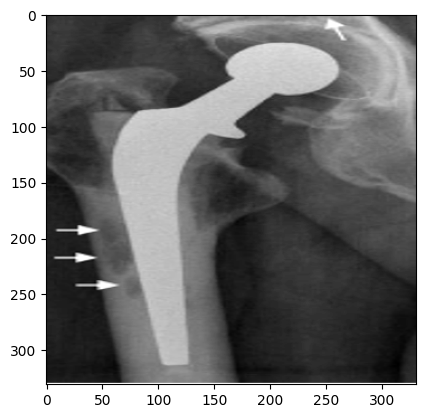

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(control_images_path[60])
imgplot = plt.imshow(img, cmap = 'gray')
plt.show()
# show a sample image from dataset

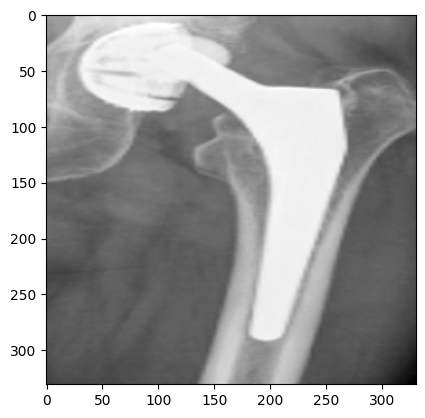

In [6]:
img = mpimg.imread(loose_images_path[9])
imgplot = plt.imshow(img, cmap = 'gray')
plt.show()
# show a sample image from dataset

In [7]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(images_path, labels, test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size = 0.8, random_state = 1) 

In [8]:
print(len(X_train))
print(len(y_test))
print(len(X_val))

131
42
33


In [9]:
#data augmentation: rotation, scaling, translation.

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Pre-processing

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
randomrotation = transforms.RandomRotation([-10,10])
resize = transforms.Resize((331,331))
scale_and_translation = transforms.RandomAffine(0,(0.05,0.05), (1,1.1))

preprocess = transforms.Compose([  
    randomrotation,
    scale_and_translation,
    resize,
    transforms.ToTensor(),
    normalize,
    ])

preprocess_test = transforms.Compose([  
    resize,
    transforms.ToTensor(),
    normalize,
    ])

In [10]:

import torch
import torchvision.models

DenseNet = torchvision.models.densenet121(pretrained=True)

/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/LooseHipVenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/LooseHipVenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
DenseNet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
DenseNet.features.denseblock4.denselayer16.norm1.parameters()

In [ ]:
num_layers = 16  # change this to the number of layers you want

layer_names = []
for i in range(1, num_layers + 1):
    layer_name = 'DenseNet.features.denseblock4.denselayer{}.norm1.parameters()'.format(i)
    layer_names.append(layer_name)

print(layer_names) 

In [12]:
for param in DenseNet.parameters():
    param.reqires_grad_ = False

for param in DenseNet.features.denseblock4.parameters():
    param.reqires_grad_ = True

for param in DenseNet.features.denseblock4.denselayer1.norm1.parameters():
    param.reqires_grad_ = False

for param in DenseNet.features.denseblock4.denselayer1.norm2.parameters():
    param.reqires_grad_ = False

#for param in DenseNet.features.denseblock4.parameters():
#    param.reqires_grad_ = True

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Modified_DenseNet(nn.Module):
    def __init__(self):
        super(Modified_DenseNet, self).__init__()
        self.name = 'Modified_DenseNet'
        self.features = nn.Sequential(*list(DenseNet.features)[:-1])
        self.linear1 = nn.Linear(1024*10*10, 1024)
        self.linear2 = nn.Linear(1024, 10)
        self.linear3 = nn.Linear(10,1)
    
    def forward(self, x):
        x = self.features(x).view(-1,1024*10*10)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        

        return x

In [14]:
def get_data_loader(paths, labels, batch_size, train = False):

    def default_loader(paths, train = False):
      img_pil =  Image.open(paths).convert('RGB')
      if train:
        img_tensor = preprocess(img_pil)
      else:
        img_tensor = preprocess_test(img_pil)
      return img_tensor

    class dataset(Dataset):
        def __init__(self, loader=default_loader):
            self.images = paths
            self.target = labels
            self.loader = loader

        def __getitem__(self, index):
            fn = self.images[index]
            img = self.loader(fn)
            target = self.target[index]
            return img,target

        def __len__(self):
            return len(self.images)
    datasetloader = DataLoader(dataset(), batch_size= batch_size)
    return datasetloader

In [15]:

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = '/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Model/' + str("model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch))
    return path


def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0

    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #############################################
        #To Enable GPU Usage
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            net = net.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)
        if torch.cuda.is_available():
          net.cuda()
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################    
        outputs = net(inputs)

        loss = criterion(outputs, labels.unsqueeze(1).float())
        for i in range(0, outputs.shape[0]):
           if outputs[i][0] > 0:
                outputs[i][0] = 1
           else:
                outputs[i][0] = 0
        corr = outputs != labels.unsqueeze(1)
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err)
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [16]:
import math

def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig

In [17]:
import numpy as np
def train_net(net, batch_size=16, learning_rate=0.01, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    train_data_loader = get_data_loader(X_train, y_train,batch_size,True)
    val_data_loader = get_data_loader(X_val, y_val,batch_size)

    ########################################################################
    # Define the Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_data_loader, 0):
            inputs, labels = data

            #############################################
            #To Enable GPU Usage
            if torch.backends.mps.is_available():
              #print('mps is available')
              device = torch.device("mps")
              net = net.to(device)
              inputs = inputs.to(device)
              labels = labels.to(device)
            if torch.cuda.is_available():
              net.cuda()
              inputs = inputs.cuda()
              labels = labels.cuda()
            #############################################
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)

            loss = criterion(outputs, 
                             labels.unsqueeze(1).float())

            loss.backward()
            optimizer.step()
            
            # Calculate the statistics

            for i in range(0, outputs.shape[0]):
              if outputs[i][0] > 0:
                outputs[i][0] = 1
              else:
                outputs[i][0] = 0

            corr = outputs != labels.unsqueeze(1)
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_data_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        if epoch > 0:
          torch.save(net.state_dict(), model_path)
    print('Finished Training')

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [18]:
# turn batch size greater than 8 might not be safe (GPU out of memory)

In [19]:
train_net(Modified_DenseNet(), batch_size=8, learning_rate=0.005, num_epochs=10)

Epoch 1: Train err: 0.46564885496183206, Train loss: 17.864892144997913 |Validation err: 0.3939393939393939, Validation loss: 3.492870330810547
Epoch 2: Train err: 0.46564885496183206, Train loss: 3.9395465652147927 |Validation err: 0.3939393939393939, Validation loss: 3.4898507595062256


In [ ]:
plot_training_curve('/Users/tuoxin/Desktop/GBC/DL Math 2/LooseHip/Model/model_Modified_DenseNet_bs4_lr0.0001_epoch1')

In [ ]:
best_model = Modified_DenseNet()
best_model.load_state_dict(torch.load('/content/model_Modified_DenseNet_bs3_lr0.0001_epoch6'))
best_model.eval()

In [ ]:
test_data_loader = get_data_loader(X_test, y_test, 1)

In [ ]:
def test_set_pred_accuracy(best_model):
  correctpred = 0
  wrongpred = 0
  
  best_model = best_model.cuda()
  for testimage, label in test_data_loader:
    testimage = testimage.cuda()
    if best_model(testimage) > 0:
      pred = 1
    else:
      pred = 0
    if label == pred:
      correctpred += 1  
    else:
      wrongpred += 1
  return correctpred / (correctpred + wrongpred)

test_set_pred_accuracy(best_model)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_confusion_matrix(best_model):
  predictions = []
  labels = []

  best_model = best_model.cuda()
  for testimage, label in test_data_loader:
    if best_model(testimage.cuda()) > 0:
      pred = 1
    else:
      pred = 0
    predictions.append(pred)
    #print(label)
    labels.append(int(label.item()))
  print(predictions)
  print(labels)
  M = confusion_matrix(labels, predictions)
  print(M)
  sns.heatmap(M, annot=True)
  plt.xlabel('Predictions')
  plt.ylabel('True labels')
  plt.show()
  print('true no / pred no: TNR', M[0][0]/(M[0][0] + M[1][0]))
  print('true yes/ pred yes: TPR', M[1][1]/(M[1][1] + M[0][1]))
  
get_confusion_matrix(best_model)

In [ ]:
import numpy as np
import sklearn
from sklearn import metrics
def get_ROC_AUC(best_model):
  preds = []
  labels = []

  best_model = best_model.cuda()
  for testimage, label in test_data_loader:
    pred = sigmoid(float(best_model(testimage.cuda()).cpu()))
    preds.append(pred)
    labels.append(int(label.item()))

  fpr, tpr, thresholds = metrics.roc_curve(labels, preds)
  metrics.auc(fpr,tpr)
  return fpr, tpr, thresholds,metrics.auc(fpr,tpr)



fpr, tpr, thresholds,auc = get_ROC_AUC(best_model)
auc

In [ ]:
# Plot ROC curve and put AUC value into the legend

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# implement ScoreCam

def upsample(input_width, input_height, image):
  image = resize(image,(input_width, input_height))
  return image

In [ ]:
def image_description(sigmoidoutput, label):
  print('The true label of this image is {a}, the prediction is {b}'.format(a = 'Loose' if label == torch.tensor(1) else 'Normal', b = 'Loose' if sigmoidoutput >0.5 else 'Normal'))
  pred = torch.tensor(1) if sigmoidoutput >0.5 else torch.tensor(0)
  return pred

In [ ]:
best_model_cuda = best_model.cuda()
Modified_DenseNet_features_cuda = Modified_DenseNet().features.cuda()
test_data_iter = iter(test_data_loader)
img_iter = iter(X_test)

In [ ]:
from PIL import Image
import seaborn as sns
import cv2

def get_score_cam_plot(heatmap_untransparent = 0.7):
        """ Plots the original images, heatmaps and the hearmaps superimposed on original images based on the cv.colormap_hot

    Arg:
        heatmap_nontransparent: how non-transparent the heatmap is on the original image, range from 0 to 1
    """
  print('Show original image')
  img = mpimg.imread(next(img_iter))
  imgplot = plt.imshow(img, cmap = 'gray')
  plt.show()

  testimage, label = next(test_data_iter)
  pred = image_description(sigmoid(best_model(testimage.cuda())), label)


  activation_map = torch.nn.functional.interpolate(Modified_DenseNet_features_cuda(testimage.cuda()).unsqueeze(axis = 0), (1920, 331, 331))
  activation_map = activation_map.squeeze()

  normalized_activations = []
  class_score = []
  for i in range(activation_map.shape[0]):
    normalized_activation = (activation_map[i,:,:] - activation_map[i,:,:].min()) / (activation_map[i,:,:].max() - activation_map[i,:,:].min() + 1e-6)
    normalized_activations.append(normalized_activation)
    normalized_activation = normalized_activation.cpu().detach().numpy()
    input_2 = np.multiply(normalized_activation, testimage)
    class_score.append(sigmoid(best_model_cuda(input_2.cuda())))

  # if the true label is control, CAM shows where the model is looking at for predicting it as a control
  if pred == torch.tensor(0):
    class_score = list(1 - np.array(class_score))
  
  print('Show heatmap')
  CAM = []
  for i in range(activation_map.shape[0]):
    CAM.append(np.multiply(class_score[i], normalized_activations[i].cpu().detach().numpy()))

  Final_CAM = np.sum(np.array(CAM), axis = 0)
  Final_CAM = np.clip(np.array(Final_CAM), 0 , None)
  ax = sns.heatmap(Final_CAM, square = True)
  ax.tick_params(left=False, bottom=False)
  plt.show()

  print('Show superimposed colormap on original image')
  normalized_Final_CAM = (Final_CAM[:,:] - Final_CAM[:,:].min()) / (Final_CAM[:,:].max() - Final_CAM[:,:].min())
  normalized_Final_CAM = np.array(normalized_Final_CAM * 255, dtype = np.uint8)
  trycam = cv2.applyColorMap(normalized_Final_CAM, cv2.COLORMAP_HOT)
  trycam = trycam/255
  plt.imshow(img, cmap = 'gray')
  plt.imshow(normalized_Final_CAM, alpha = heatmap_untransparent)
  plt.show()


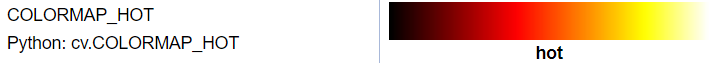

In [ ]:
# Visulize a few ScoreCam plots
get_score_cam_plot(0.7)

In [ ]:
get_score_cam_plot(0.7)

In [ ]:
get_score_cam_plot(0.7)

In [ ]:
get_score_cam_plot(0.7)

In [ ]:
get_score_cam_plot(0.7)

In [ ]:
get_score_cam_plot(0.7)

In [ ]:
get_score_cam_plot(0.7)

In [ ]:
get_score_cam_plot(0.7)